Import all our packages and local bits

In [1]:
import sys
sys.path.append("../")

In [2]:
%env PYANALYSISUTILS=/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils

env: PYANALYSISUTILS=/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils


In [3]:
sys.argv = ["--at all"] 
import XGB_board

Driver       :: INFO     ::       Setting up Driver from /user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/Driver.py
Driver       :: INFO     ::       NO VARIABLES SUPPLIED ON THE COMMAND LINE, JUST DRAWING ONE BIN
Driver       :: INFO     ::       Variables from the command line...
Driver       :: INFO     ::       	 {'var': '1', 'nbins': 1, 'xmin': 0.0, 'xmax': 2.0}


No ROOT module avoid using functions with root


In [4]:
import modules
import numpy as np
import torch.nn

In [5]:
from skorch import NeuralNetClassifier, callbacks

Gather our data

In [6]:
X = np.load("/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/X_train.npy").astype(np.float32)
Y = np.load("/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/Y_train.npy").astype(np.int64)
W = np.prod(np.load("/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/W_train.npy").astype(np.float32),axis=1)
X_mini = X[:100000]
Y_mini = Y[:100000]
W_mini = W[:100000]


In [7]:
X_test = np.load("/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/X_test.npy").astype(np.float32)
Y_test = np.load("/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/Y_test.npy").astype(np.int64)
W_test = np.prod(np.load("/user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/W_test.npy").astype(np.float32),axis=1)

X_test_mini = X_test[:100000]
Y_test_mini = Y_test[:100000]
W_test_mini = W_test[:100000]

{'color': 'green'}
{'color': 'red'}


array([[ 1.6381232 ],
       [-0.38302758],
       [ 0.16385408],
       ...,
       [ 0.64452076],
       [-1.112225  ],
       [ 1.9580181 ]], dtype=float32)

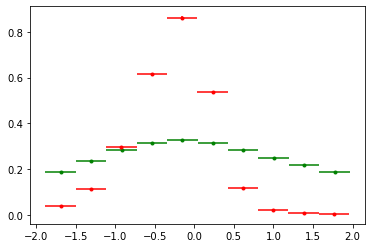

In [8]:
import matplotlib.pyplot as plt
import utils
plt.figure()
X_sub = X_test[:, 5:6]
X_sub_signal = X_sub[np.where(Y_test==0)]
X_sub_bkg = X_sub[np.where(Y_test!=0)]
plot_var = utils.utils.hist_errorbars(X_sub_bkg, normed=True, color="green")
plot_var = utils.utils.hist_errorbars(X_sub_signal, normed=True, color="red")
#plt.show()
X_sub

In [9]:
# #Fake data 
# from sklearn.datasets import make_classification
# X, Y = make_classification(10000, 20, n_classes=5, n_informative=10, random_state=0, class_sep=5)
# X, X_test = X[:8000],X[8000:]
# Y, Y_test = Y[:8000],Y[8000:]
# #X_test, Y_test = make_classification(10000, 20, n_informative=10, random_state=0)
# X, Y = X.astype(np.float32), Y.astype(np.int64)
# X_test, Y_test = X_test.astype(np.float32), Y_test.astype(np.int64)

In [16]:
module = modules.Cat(X_size=len(X[0]), num_classes=5)
#module = modules.ClassifierModule()

In [17]:
def to_one_hot(Y):
    num_classes = 5
    targets = Y.reshape(-1)
    return np.eye(num_classes)[targets]

In [18]:
#net = NeuralNetClassifier( module, max_epochs=10, lr=1e-2, iterator_train__shuffle=True, callbacks=[callbacks.ProgressBar()], batch_size=100)
net = NeuralNetClassifier( module, max_epochs=10, optimizer = torch.optim.Adam, optimizer__lr=1e-3, iterator_train__shuffle=True, callbacks=[callbacks.ProgressBar(), callbacks.EpochScoring('roc_auc_ovr', target_extractor=to_one_hot, lower_is_better=False)], batch_size=100)

In [19]:

%time net.fit(X,Y)

  epoch    roc_auc_ovr    train_loss    valid_acc    valid_loss      dur
-------  -------------  ------------  -----------  ------------  -------
      1         0.7717        0.5936       0.8353        0.5809  97.7589


      2         0.7752        0.5772       0.8355        0.5756  101.6954


      3         0.7795        0.5738       0.8361        0.5711  100.0376


      4         0.7804        0.5715       0.8358        0.5711  98.0309


      5         0.7819        0.5699       0.8366        0.5698  98.6545


      6         0.7823        0.5689       0.8363        0.5696  99.7811


      7         0.7838        0.5679       0.8367        0.5668  98.6319


      8         0.7841        0.5673       0.8368        0.5664  97.2205


      9         0.7842        0.5668       0.8369        0.5705  98.0224


     10         0.7849        0.5665       0.8369        0.5669  95.4521
CPU times: user 17min 42s, sys: 13 s, total: 17min 55s
Wall time: 16min 53s


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Cat(
    (dropout10): AlphaDropout(p=0.1, inplace=False)
    (dropout20): AlphaDropout(p=0.2, inplace=False)
    (dropout30): AlphaDropout(p=0.3, inplace=False)
    (linear_input): Linear(in_features=35, out_features=35, bias=True)
    (linear): Linear(in_features=35, out_features=35, bias=True)
    (linear_output): Linear(in_features=35, out_features=5, bias=True)
  ),
)

In [20]:
import tensorboard_modules
import utils.utils

In [21]:
import importlib
importlib.reload(tensorboard_modules)
#import utils.utils
importlib.reload(utils.utils)
board = tensorboard_modules.board_object(net,X_mini,"cpu")

Driver       :: INFO     ::       Setting up Driver from /user/hteagle/AnalysisDirectory/Rel21/Base.21.2.72/athena/PyAnalysisUtils/Driver.py
Driver       :: INFO     ::       NO VARIABLES SUPPLIED ON THE COMMAND LINE, JUST DRAWING ONE BIN
Driver       :: INFO     ::       Variables from the command line...
Driver       :: INFO     ::       	 {'var': '1', 'nbins': 1, 'xmin': 0.0, 'xmax': 2.0}


New output:runs/2020-12-30/16:46:38.972511


{'label': 'test_bkg', 'color': 'green'}
{'label': 'test_sig', 'color': 'red'}


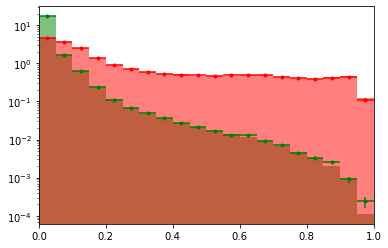

In [22]:
plot = board.draw_train_validation(X, Y, W, X_test, Y_test, W_test, net, draw=False)

#plot = board.draw_train_validation(X_mini, Y_mini, W_mini, X_test_mini, Y_test_mini, W_test_mini, net, draw=False)
